# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imagehash
from PIL import Image
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Check if TensorFlow is Detecting GPU

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print("Found GPU device(s):")
    for device in gpu_devices:
        print(device)
else:
    print("No GPU devices found. TensorFlow will use CPU.")

Found GPU device(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-04-16 15:50:08.027390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 15:50:08.241500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 15:50:08.241717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Define the Default Path

In [3]:
# Define root directories and CSV paths
root_dirs = {
    'asphalt': ('data_asphalt/', 'data_asphalt/data.csv'),
    'desert': ('data_desert/', 'data_desert/data.csv'),
    'offroad': ('data_offroad/', 'data_offroad/data.csv'),
    'mountain': ('data_mountain/', 'data_mountain/data.csv')
}

# Remove Stationary and Redundant Images from Dataset

In [11]:
def clean_dataset(root_dir, csv_path):
    # Load the dataset
    df = pd.read_csv(csv_path)

    # Identify rows where linear.x is 0
    zero_linear_x = df[df['linear_x'] == 0]

    # Remove these rows from the dataframe
    df_cleaned = df[df['linear_x'] != 0]

    # Overwrite the cleaned dataframe to the current CSV
    df_cleaned.to_csv(csv_path, index=False)

    # Remove corresponding images from the folder
    for image_name in zero_linear_x['image_name']:
        image_path = os.path.join(root_dir, image_name)
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f'Removed: {image_path}')
        else:
            print(f'File not found: {image_path}')

    print("Dataset cleaned and updated.")

In [5]:
def clean_dataset_rm(root_dir, csv_path):
    # Load the dataset
    df = pd.read_csv(csv_path)

    # Identify rows where linear.x is 0 and remove them
    df_cleaned = df[df['linear_x'] != 0]
    print(f"Removed {len(df) - len(df_cleaned)} images with linear.x == 0.")

    # Deduplication: Compute image hashes and identify duplicates
    hashes = {}
    duplicates = []
    for index, row in df_cleaned.iterrows():
        img_path = os.path.join(root_dir, row['image_name'])
        try:
            with Image.open(img_path) as img:
                # Computing a perceptual hash of the image
                img_hash = str(imagehash.average_hash(img, hash_size=8))
                if img_hash in hashes:
                    # If the hash is already known, mark the image as duplicate
                    duplicates.append(row['image_name'])
                else:
                    # Otherwise, add the hash to the dictionary
                    hashes[img_hash] = img_path
        except IOError as e:
            print(f"Error opening image {img_path}: {e}")

    # Remove identified duplicate images
    for duplicate_name in duplicates:
        duplicate_path = os.path.join(root_dir, duplicate_name)
        if os.path.exists(duplicate_path):
            os.remove(duplicate_path)
            print(f'Removed duplicate: {duplicate_path}')

    # Filtering out the duplicate entries from the DataFrame
    df_final = df_cleaned[~df_cleaned['image_name'].isin(duplicates)]

    # Overwrite the cleaned dataframe to the current CSV, excluding duplicates and zero linear.x
    df_final.to_csv(csv_path, index=False)

    print(f"Removed {len(duplicates)} duplicate images.")
    print("Dataset cleaned and updated.")

# Create Training Dataset

In [6]:
def load_and_preprocess_data(csv_path, root_dir):
    data = pd.read_csv(csv_path)
    images = []
    angular_zs = []

    for _, row in data.iterrows():
        img_path = os.path.join(root_dir, row['image_name'])
        image = np.array(Image.open(img_path))
        images.append(image)
        angular_zs.append(row['angular_z'])

    # Convert lists to numpy arrays and normalize images
    images = np.array(images).astype('float32') / 255.0
    angular_zs = np.array(angular_zs)

    print("Loaded dataset.")

    return images, angular_zs

# Shuffle and Unpack Dataset

In [7]:
def shuffle_and_unpack_data(images, angular_zs):
    """
    Shuffles and unpacks images and their corresponding labels (angular_zs).
    
    Parameters:
    - images: numpy array of images.
    - angular_zs: numpy array of angular_z values.
    
    Returns:
    - shuffled_images: numpy array of shuffled images.
    - shuffled_angular_zs: numpy array of shuffled angular_z values.
    """
    # Pair up images and labels
    img_label_set = list(zip(images, angular_zs))
    
    # Shuffle the paired dataset
    np.random.shuffle(img_label_set)
    
    # Unpack the shuffled dataset back into images and labels
    shuffled_images, shuffled_angular_zs = zip(*img_label_set)
    
    # Convert them back to numpy arrays
    shuffled_images = np.array(shuffled_images)
    shuffled_angular_zs = np.array(shuffled_angular_zs)

    print("Shuffled dataset.")

    return shuffled_images, shuffled_angular_zs

# Process Asphalt

In [ ]:
# Clean the asphalt dataset
root_dir_asphalt, csv_path_asphalt = root_dirs['asphalt']
clean_dataset_rm(root_dir_asphalt, csv_path_asphalt)

# Load and preprocess data for the asphalt environment
images_asphalt, angular_zs_asphalt = load_and_preprocess_data(csv_path_asphalt, root_dir_asphalt)

# Shuffle and unpack for the asphalt environment
images_asphalt, angular_zs_asphalt = shuffle_and_unpack_data(images_asphalt, angular_zs_asphalt)

# Process Desert

In [ ]:
# Clean the desert dataset
root_dir_desert, csv_path_desert = root_dirs['desert']
clean_dataset_rm(root_dir_desert, csv_path_desert)

# Load and preprocess data for the desert environment
images_desert, angular_zs_desert = load_and_preprocess_data(csv_path_desert, root_dir_desert)

# Shuffle and unpack for the desert environment
images_desert, angular_zs_desert = shuffle_and_unpack_data(images_desert, angular_zs_desert)

# Process Offroad

In [ ]:
# Clean the offroad dataset
root_dir_offroad, csv_path_offroad = root_dirs['offroad']
clean_dataset_rm(root_dir_offroad, csv_path_offroad)

# Load and preprocess data for the offroad environment
images_offroad, angular_zs_offroad = load_and_preprocess_data(csv_path_offroad, root_dir_offroad)

# Shuffle and unpack for the offroad environment
images_offroad, angular_zs_offroad = shuffle_and_unpack_data(images_offroad, angular_zs_offroad)

# Process Mountain

In [ ]:
# Clean the mountain dataset
root_dir_mountain, csv_path_mountain = root_dirs['mountain']
clean_dataset_rm(root_dir_mountain, csv_path_mountain)

# Load and preprocess data for the mountain environment
images_mountain, angular_zs_mountain = load_and_preprocess_data(csv_path_mountain, root_dir_mountain)

# Shuffle and unpack for the mountain environment
images_mountain, angular_zs_mountain = shuffle_and_unpack_data(images_mountain, angular_zs_mountain)

# Define CNN Architecture

In [17]:
def create_cnn(input_shape):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Convolutional Layer 4
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))

    # # Dense Layer 1
    model.add(layers.Dense(512, activation='relu'))
    # Dense Layer 2
    model.add(layers.Dense(256, activation='relu'))

    # Output Layer with one neuron since it's a regression problem
    model.add(layers.Dense(1))

    return model

In [18]:
def create_cnn_special(input_shape):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 4
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 5
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Convolutional Layer 6
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))

    # # Dense Layer 1
    model.add(layers.Dense(512, activation='relu'))
    # Dense Layer 2
    model.add(layers.Dense(256, activation='relu'))

    # Output Layer with one neuron since it's a regression problem
    model.add(layers.Dense(1))

    return model

# Compile and Train the Model

## Asphalt

In [30]:
# Create the CNN model
input_shape_asphalt = images_asphalt.shape[1:]  # Get the input shape from the asphalt dataset
cnn_asphalt = create_cnn(input_shape_asphalt)

# Compile the model
cnn_asphalt.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=0.005), metrics=['accuracy'])

# Early stopping callback to stop training when the validation loss has stopped improving
early_stopping_asphalt = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr_asphalt = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=15, verbose=1, min_lr=1e-7)

In [20]:
# Visualize the model
cnn_asphalt.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 72, 128, 32)       2432      
                                                                 
 batch_normalization (BatchN  (None, 72, 128, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 36, 64, 64)       256       
 hNormalization)                                                 
                                                        

## Desert

In [31]:
# Create the CNN model
input_shape_desert = images_desert.shape[1:]  # Get the input shape from the desert dataset
cnn_desert = create_cnn_special(input_shape_desert)

# Compile the model
cnn_desert.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=0.0015), metrics='accuracy')

# Early stopping callback to stop training when the validation loss has stopped improving
early_stopping_desert = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr_desert = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=10, verbose=1, min_lr=1e-7)

In [24]:
# Visualize the model
cnn_desert.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 72, 128, 32)       2432      
                                                                 
 batch_normalization_8 (Batc  (None, 72, 128, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 36, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 36, 64, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 36, 64, 64)       256       
 hNormalization)                                                 
                                                      

## Offroad

In [32]:
# Create the CNN model
input_shape_offroad = images_offroad.shape[1:]  # Get the input shape from the offroad dataset
cnn_offroad = create_cnn_special(input_shape_offroad)

# Compile the model
cnn_offroad.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

# Early stopping callback to stop training when the validation loss has stopped improving
early_stopping_offroad = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr_offroad = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=10, verbose=1, min_lr=1e-7)

In [26]:
# Visualize the model
cnn_offroad.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 72, 128, 32)       2432      
                                                                 
 batch_normalization_14 (Bat  (None, 72, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 36, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 36, 64, 64)        18496     
                                                                 
 batch_normalization_15 (Bat  (None, 36, 64, 64)       256       
 chNormalization)                                                
                                                      

## Mountain

In [33]:
# Create the CNN model
input_shape_mountain = images_mountain.shape[1:]  # Get the input shape from the mountain dataset
cnn_mountain = create_cnn(input_shape_mountain)

# Compile the model
cnn_mountain.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=0.0005), metrics=['accuracy'])

# Early stopping callback to stop training when the validation loss has stopped improving
early_stopping_mountain = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr_mountain = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=10, verbose=1, min_lr=1e-7)

In [28]:
# Visualize the model
cnn_mountain.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 72, 128, 32)       2432      
                                                                 
 batch_normalization_20 (Bat  (None, 72, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 36, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 36, 64, 64)        18496     
                                                                 
 batch_normalization_21 (Bat  (None, 36, 64, 64)       256       
 chNormalization)                                                
                                                      

# Train the Model

## Asphalt

In [34]:
history_asphalt = cnn_asphalt.fit(
    images_asphalt, 
    angular_zs_asphalt, 
    validation_split=0.20, 
    epochs=200, 
    batch_size=8, 
    callbacks=[early_stopping_asphalt, reduce_lr_asphalt]
)

Epoch 1/200
94/94 [==============================] - 1s 7ms/step - loss: 1406.2255 - accuracy: 0.3757 - val_loss: 4.3528 - val_accuracy: 0.2299 - lr: 0.0050
Epoch 2/200
94/94 [==============================] - 0s 5ms/step - loss: 1.1159 - accuracy: 0.4345 - val_loss: 36.0836 - val_accuracy: 0.5080 - lr: 0.0050
Epoch 3/200
94/94 [==============================] - 0s 5ms/step - loss: 25.0626 - accuracy: 0.4826 - val_loss: 0.5376 - val_accuracy: 0.5027 - lr: 0.0050
Epoch 4/200
94/94 [==============================] - 0s 5ms/step - loss: 0.6054 - accuracy: 0.4799 - val_loss: 1.5390 - val_accuracy: 0.5080 - lr: 0.0050
Epoch 5/200
94/94 [==============================] - 0s 5ms/step - loss: 1.5676 - accuracy: 0.4759 - val_loss: 0.5754 - val_accuracy: 0.4759 - lr: 0.0050
Epoch 6/200
94/94 [==============================] - 0s 5ms/step - loss: 0.9369 - accuracy: 0.4666 - val_loss: 0.5277 - val_accuracy: 0.5080 - lr: 0.0050
Epoch 7/200
94/94 [==============================] - 0s 5ms/step - loss

## Desert

In [36]:
history_desert = cnn_desert.fit(
    images_desert, 
    angular_zs_desert, 
    validation_split=0.2, 
    epochs=200, 
    batch_size=4, 
    callbacks=[early_stopping_desert, reduce_lr_desert]
)

Epoch 1/200
135/135 [==============================] - 2s 7ms/step - loss: 6.7256 - accuracy: 0.3315 - val_loss: 0.6099 - val_accuracy: 0.5441 - lr: 0.0015
Epoch 2/200
135/135 [==============================] - 1s 6ms/step - loss: 0.8365 - accuracy: 0.3704 - val_loss: 12.5802 - val_accuracy: 0.5441 - lr: 0.0015
Epoch 3/200
135/135 [==============================] - 1s 6ms/step - loss: 0.6273 - accuracy: 0.3796 - val_loss: 2.6957 - val_accuracy: 0.3676 - lr: 0.0015
Epoch 4/200
135/135 [==============================] - 1s 6ms/step - loss: 0.5357 - accuracy: 0.4000 - val_loss: 0.6632 - val_accuracy: 0.1691 - lr: 0.0015
Epoch 5/200
135/135 [==============================] - 1s 6ms/step - loss: 0.4387 - accuracy: 0.4000 - val_loss: 1.3752 - val_accuracy: 0.5441 - lr: 0.0015
Epoch 6/200
135/135 [==============================] - 1s 6ms/step - loss: 0.3609 - accuracy: 0.4056 - val_loss: 0.2857 - val_accuracy: 0.4485 - lr: 0.0015
Epoch 7/200
135/135 [==============================] - 1s 6ms/s

## Offroad

In [37]:
history_offroad = cnn_offroad.fit(
    images_offroad, 
    angular_zs_offroad, 
    validation_split=0.20, 
    epochs=200, 
    batch_size=8, 
    callbacks=[early_stopping_offroad, reduce_lr_offroad]
)

Epoch 1/200
57/57 [==============================] - 1s 12ms/step - loss: 5.7282 - accuracy: 0.3991 - val_loss: 0.4922 - val_accuracy: 0.6018 - lr: 0.0010
Epoch 2/200
57/57 [==============================] - 0s 7ms/step - loss: 0.8397 - accuracy: 0.4013 - val_loss: 0.4673 - val_accuracy: 0.6018 - lr: 0.0010
Epoch 3/200
57/57 [==============================] - 0s 6ms/step - loss: 0.5842 - accuracy: 0.4967 - val_loss: 0.5042 - val_accuracy: 0.6018 - lr: 0.0010
Epoch 4/200
57/57 [==============================] - 0s 7ms/step - loss: 0.5361 - accuracy: 0.4701 - val_loss: 0.4794 - val_accuracy: 0.6018 - lr: 0.0010
Epoch 5/200
57/57 [==============================] - 0s 6ms/step - loss: 0.5301 - accuracy: 0.4967 - val_loss: 0.9920 - val_accuracy: 0.6018 - lr: 0.0010
Epoch 6/200
57/57 [==============================] - 0s 7ms/step - loss: 0.4919 - accuracy: 0.5211 - val_loss: 0.6212 - val_accuracy: 0.5664 - lr: 0.0010
Epoch 7/200
57/57 [==============================] - 0s 6ms/step - loss: 0.

## Mountain

In [38]:
history_mountain = cnn_mountain.fit(
    images_mountain, 
    angular_zs_mountain, 
    validation_split=0.20, 
    epochs=200, 
    batch_size=8, 
    callbacks=[early_stopping_mountain, reduce_lr_mountain]
)

Epoch 1/200
119/119 [==============================] - 1s 6ms/step - loss: 5.4488 - accuracy: 0.4443 - val_loss: 0.5151 - val_accuracy: 0.0924 - lr: 5.0000e-04
Epoch 2/200
119/119 [==============================] - 1s 5ms/step - loss: 0.5937 - accuracy: 0.5158 - val_loss: 0.3920 - val_accuracy: 0.5798 - lr: 5.0000e-04
Epoch 3/200
119/119 [==============================] - 1s 5ms/step - loss: 0.4242 - accuracy: 0.5620 - val_loss: 0.2668 - val_accuracy: 0.6597 - lr: 5.0000e-04
Epoch 4/200
119/119 [==============================] - 1s 5ms/step - loss: 0.3571 - accuracy: 0.5746 - val_loss: 0.4814 - val_accuracy: 0.3571 - lr: 5.0000e-04
Epoch 5/200
119/119 [==============================] - 1s 5ms/step - loss: 0.3299 - accuracy: 0.6050 - val_loss: 0.3831 - val_accuracy: 0.6303 - lr: 5.0000e-04
Epoch 6/200
119/119 [==============================] - 1s 5ms/step - loss: 0.3008 - accuracy: 0.6082 - val_loss: 0.3745 - val_accuracy: 0.7017 - lr: 5.0000e-04
Epoch 7/200
119/119 [===================

# Plot Model Performance

In [39]:
def plot_model_performance(history, title='Model Loss and Accuracy'):
    _, ax1 = plt.subplots(figsize=(10, 5))

    # Plot training and validation loss on the first y-axis
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(history.history['loss'], label='Training Loss', color='tab:red', linestyle='--')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis sharing the same x-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:blue')
    ax2.plot(history.history['accuracy'], label='Training Accuracy', color='tab:blue', linestyle='--')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Add legend and title to the plot
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')
    plt.title(title)
    plt.show()

## Asphalt

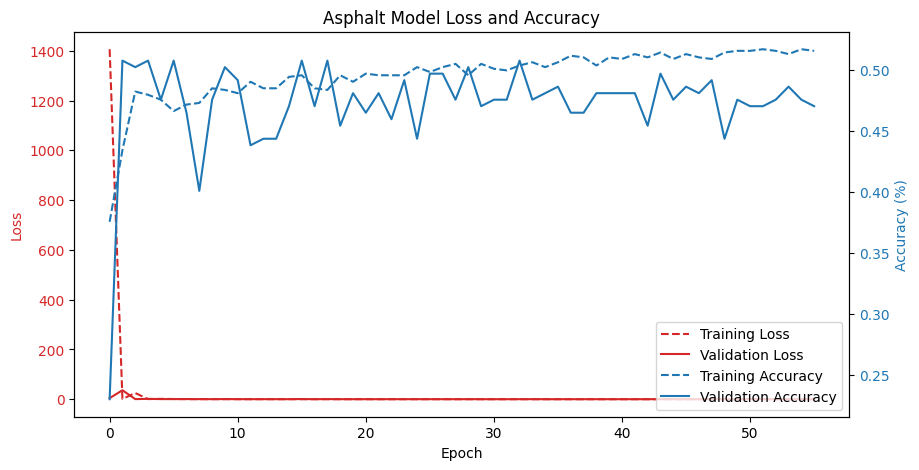

In [40]:
plot_model_performance(history_asphalt, title='Asphalt Model Loss and Accuracy')

## Desert

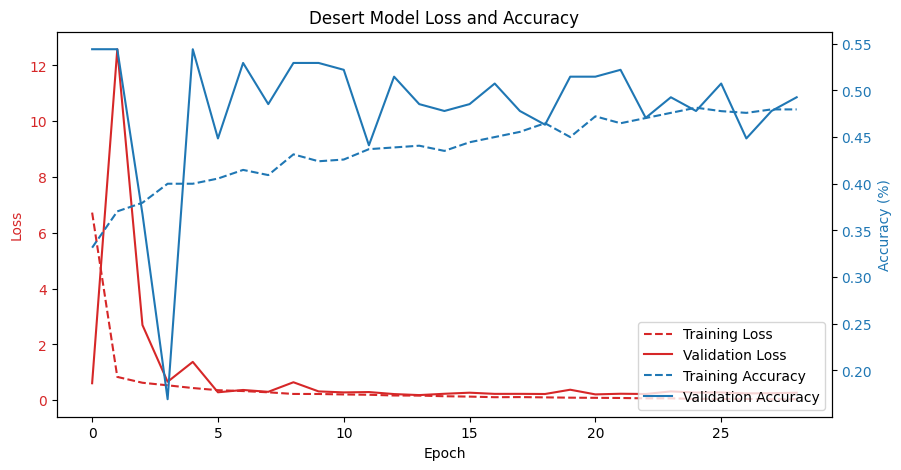

In [41]:
plot_model_performance(history_desert, title='Desert Model Loss and Accuracy')

## Offroad

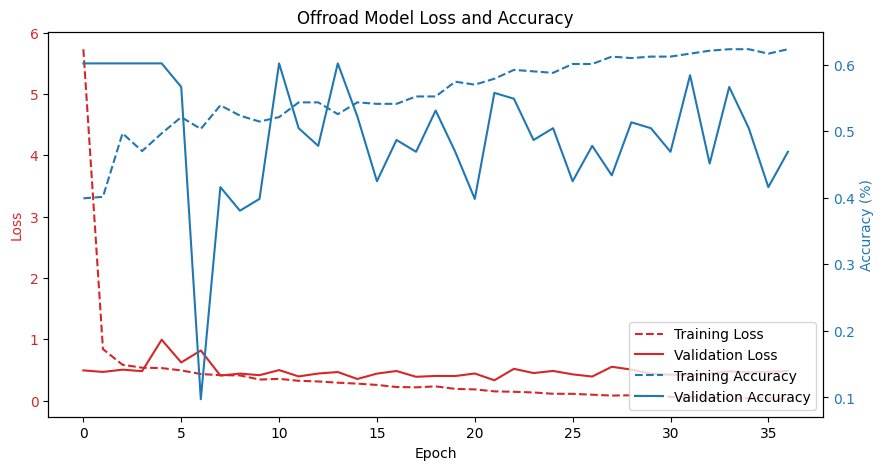

In [42]:
plot_model_performance(history_offroad, title='Offroad Model Loss and Accuracy')

## Mountain

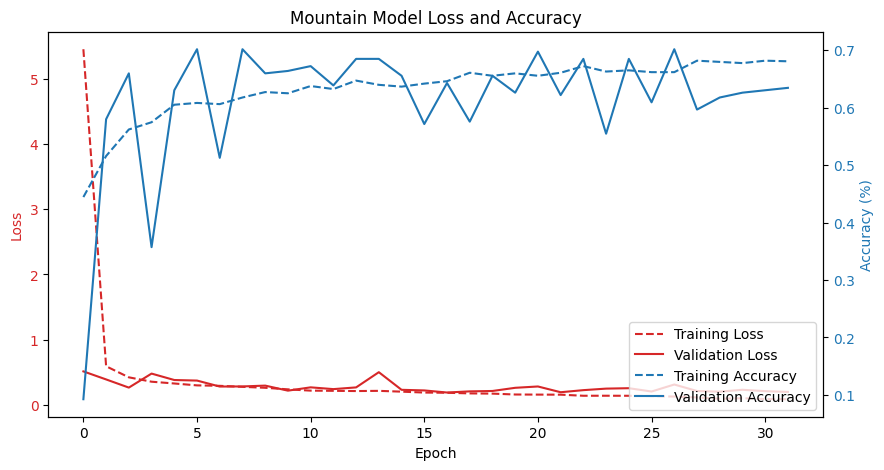

In [43]:
plot_model_performance(history_mountain, title='Mountain Model Loss and Accuracy')

# Save the Model

## Asphalt

In [62]:
cnn_asphalt.save('trained_model_asphalt.h5')

## Desert

In [807]:
cnn_desert.save('trained_model_desert.h5')

## Offroad

In [326]:
cnn_offroad.save('trained_model_offroad.h5')

## Mountain

In [379]:
cnn_mountain.save('trained_model_mountain.h5')

# Perform Integer Quantization on the Model

## Asphalt

In [ ]:
# Load the asphalt model
model_name_asphalt = 'trained_model_asphalt.h5'
model_asphalt = load_model(model_name_asphalt)

# Prepare the TensorFlow Lite converter for weight quantization
converter_asphalt = tf.lite.TFLiteConverter.from_keras_model(model_asphalt)
converter_asphalt.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_quantized_model_asphalt = converter_asphalt.convert()

# Save the quantized model
quantized_model_name_asphalt = model_name_asphalt.replace('.h5', '_weight_quantized.tflite')
with open(quantized_model_name_asphalt, 'wb') as f:
    f.write(tflite_quantized_model_asphalt)

print(f"Weight-quantized model saved as {quantized_model_name_asphalt}")

## Desert

In [ ]:
# Load the desert model
model_name_desert = 'trained_model_desert.h5'
model_desert = load_model(model_name_desert)

# Prepare the TensorFlow Lite converter for weight quantization
converter_desert = tf.lite.TFLiteConverter.from_keras_model(model_desert)
converter_desert.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_quantized_model_desert = converter_desert.convert()

# Save the quantized model
quantized_model_name_desert = model_name_desert.replace('.h5', '_weight_quantized.tflite')
with open(quantized_model_name_desert, 'wb') as f:
    f.write(tflite_quantized_model_desert)

print(f"Weight-quantized model saved as {quantized_model_name_desert}")

## Offroad

In [ ]:
# Load the offroad model
model_name_offroad = 'trained_model_offroad.h5'
model_offroad = load_model(model_name_offroad)

# Prepare the TensorFlow Lite converter for weight quantization
converter_offroad = tf.lite.TFLiteConverter.from_keras_model(model_offroad)
converter_offroad.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_quantized_model_offroad = converter_offroad.convert()

# Save the quantized model
quantized_model_name_offroad = model_name_offroad.replace('.h5', '_weight_quantized.tflite')
with open(quantized_model_name_offroad, 'wb') as f:
    f.write(tflite_quantized_model_offroad)

print(f"Weight-quantized model saved as {quantized_model_name_offroad}")

## Mountain

In [ ]:
# Load the mountain model
model_name_mountain = 'trained_model_mountain.h5'
model_mountain = load_model(model_name_mountain)

# Prepare the TensorFlow Lite converter for weight quantization
converter_mountain = tf.lite.TFLiteConverter.from_keras_model(model_mountain)
converter_mountain.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_quantized_model_mountain = converter_mountain.convert()

# Save the quantized model
quantized_model_name_mountain = model_name_offroad.replace('.h5', '_weight_quantized.tflite')
with open(quantized_model_name_mountain, 'wb') as f:
    f.write(tflite_quantized_model_mountain)

print(f"Weight-quantized model saved as {quantized_model_name_mountain}")